<a href="https://colab.research.google.com/github/rhehgus02/ESAA_OB/blob/main/%ED%8C%8C%EC%9D%B4%EC%8D%AC_%EB%94%A5%EB%9F%AC%EB%8B%9D_%ED%85%90%EC%84%9C%ED%94%8C%EB%A1%9C(2)_%EC%BC%80%EB%9D%BC%EC%8A%A4(2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **4. 모델 세부 설정**

* mnist 데이터셋 다시 사용

In [1]:
import tensorflow as tf

# 케라스의 내장 데이터셋에서 mnist 데이터셋 로드
mnist = tf.keras.datasets.mnist

# load_data()로 데이터셋 로드
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# 로드된 데이터셋 확인
print('train set:', x_train.shape, y_train.shape)
print('test set:', x_test.shape, y_test.shape)

# 데이터 정규화
x_train = x_train/ x_train.max()  # max: 255
x_test = x_test / x_test.max()    # max: 255

11490434/11490434 [==============================] - 0s 0us/step
train set: (60000, 28, 28) (60000,)
test set: (10000, 28, 28) (10000,)


---

### **4-1. 초기값 설정**

* 레이어의 초기화 방법을 다르게 설정 가능함

    * Dense 레이어 기본 초기화 방법: Glorot Uniform

        -> GlorotUniform 초기화 방법을 HeNormal로 변경하기 위해서는 `kernel_initializer` 매개변수에 설정하면 됨



In [2]:
dense = tf.keras.layers.Dense(256, activation='relu')
dense.get_config()['kernel_initializer']

{'module': 'keras.initializers',
 'class_name': 'GlorotUniform',
 'config': {'seed': None},
 'registered_name': None}

In [3]:
# 문자열 초기화
dense = tf.keras.layers.Dense(256, kernel_initializer='he_normal', activation='relu')
print(dense.get_config()['kernel_initializer'])

# 클래스 인스턴스 초기화
he_normal = tf.keras.initializers.HeNormal()
dense = tf.keras.layers.Dense(256, kernel_initializer=he_normal, activation='relu')
print(dense.get_config()['kernel_initializer'])

{'module': 'keras.initializers', 'class_name': 'HeNormal', 'config': {'seed': None}, 'registered_name': None}
{'module': 'keras.initializers', 'class_name': 'HeNormal', 'config': {'seed': None}, 'registered_name': None}


---

### **4-2. 규제(Regularization)**

* 모델의 과대적합을 해소하기 위해 L1, L2 규제를 적용

    -> 텐서플로 케라스 레이어는 기본값으로 규제를 적용하고 있지 않음

    -> 레이어에 규제를 적용하기 위해서는 별도로 설정해줘야 함


In [4]:
# 기본값
dense = tf.keras.layers.Dense(256, activation='relu')
dense.get_config()

{'name': 'dense_3',
 'trainable': True,
 'dtype': 'float32',
 'units': 256,
 'activation': 'relu',
 'use_bias': True,
 'kernel_initializer': {'module': 'keras.initializers',
  'class_name': 'GlorotUniform',
  'config': {'seed': None},
  'registered_name': None},
 'bias_initializer': {'module': 'keras.initializers',
  'class_name': 'Zeros',
  'config': {},
  'registered_name': None},
 'kernel_regularizer': None,
 'bias_regularizer': None,
 'activity_regularizer': None,
 'kernel_constraint': None,
 'bias_constraint': None}

>> `kernel_regularizer` 설정이 None임

* 규제를 적용하기 위해서는 `kernel_regularizer`에 규제를 지정하면 됨


In [5]:
# L1 규제 적용
dense = tf.keras.layers.Dense(256, kernel_regularizer='l1', activation='relu')
print(dense.get_config()['kernel_regularizer'])

# 클래스 인스턴스 적용, alpha=0.1 변경
regularizer = tf.keras.regularizers.l1(l1=0.1)
dense = tf.keras.layers.Dense(256, kernel_regularizer=regularizer, activation='relu')
print(dense.get_config()['kernel_regularizer'])

{'module': 'keras.regularizers', 'class_name': 'L1', 'config': {'l1': 0.009999999776482582}, 'registered_name': None}
{'module': 'keras.regularizers', 'class_name': 'L1', 'config': {'l1': 0.10000000149011612}, 'registered_name': None}


---

### **4-3. 드롭아웃(Dropout)**

* 딥러닝 모델의 가장 큰 난제가 과대적합 문제임

    -> 딥러닝 모델의 층이 넓고 깊어질 때 모델은 훈련에 주어진 샘플에 과하게 적합하도록 학습하는 경향이 있기 때문

    -> 따라서 훈련 데이터셋에 너무 적응하여 검증 데이터셋이나 테스트 데이터셋에 대해 일반화된 성능을 갖지 못하는 문제가 자주 발생

* 드롭아웃은 모델의 과대적합 문제를 해결하기 위해 제안된 아이디어

    * 노드의 일부 신호를 임의로 삭제해서 모델이 쉽게 과대적합 되는 것을 방지

        -> 모델이 학습하는 가중치 파라미터 개수가 현저하게 줄어듦

    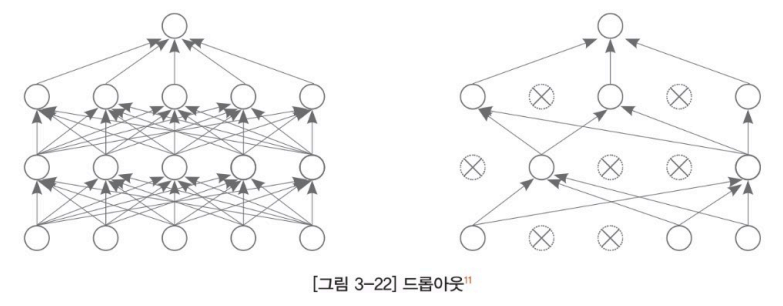

* 중요한 점은 모델이 훈련할 때는 드롭아웃이 적용되어 노드 중 일부만 훈련하게 되지만, 예측 시점에는 모든 노드들이 활용된다는 것


In [6]:
# Dropout 25% 비율 적용 (25% 노드가 삭제)
tf.keras.layers.Dropout(0.25)

---

### **4-4. 배치 정규화(Batch Normalization)**

* 배치 정규화: 각 층에서 활성화 함수를 통과하기 전 미니 배치의 스케일을 정규화함

    -> 다음 층으로 데이터가 전달되기 전에 스케일을 조정하기 때문에 보다 안정적인 훈련이 가능하고 성능을 크게 향상시킬 수 있음

    -> 크고 복잡한 데이터셋에 대해서는 배치 정규화 유무가 모델 성능에 크게 영향을 미치는 경우도 있음

* 배치 정규화 층은 케라스에서 클래스 함수로 지원하기 때문에 별도로 코드를 구현할 필요 없이 클래스 인스턴스를 생성하여 추가해주면 됨



In [7]:
# Model A: Dense + ReLU
model_a = tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=(28, 28)),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax'),
])
model_a.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense_6 (Dense)             (None, 64)                50240     
                                                                 
 dense_7 (Dense)             (None, 32)                2080      
                                                                 
 dense_8 (Dense)             (None, 10)                330       
                                                                 
Total params: 52650 (205.66 KB)
Trainable params: 52650 (205.66 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [8]:
# Model B: Dense + BatchNorm + ReLU
model_b = tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=(28, 28)),
        tf.keras.layers.Dense(64),
        # 배치 정규화 적용
        tf.keras.layers.BatchNormalization(),
        # 배치 정규화 후 활성화 함수 적용
        tf.keras.layers.Activation('relu'),

        tf.keras.layers.Dense(32),
        # 배치 정규화 적용
        tf.keras.layers.BatchNormalization(),
        # 배치 정규화 후 활성화 함수 적용
        tf.keras.layers.Activation('relu'),

        tf.keras.layers.Dense(10, activation='softmax'),
])
model_b.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_9 (Dense)             (None, 64)                50240     
                                                                 
 batch_normalization (Batch  (None, 64)                256       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 64)                0         
                                                                 
 dense_10 (Dense)            (None, 32)                2080      
                                                                 
 batch_normalization_1 (Bat  (None, 32)                128       
 chNormalization)                                     

>> 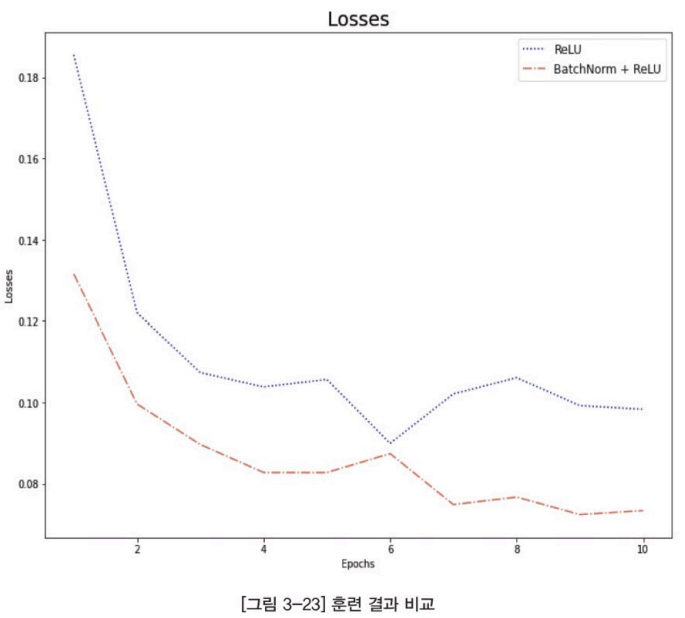

>> 배치 정규화만 추가했는데 손실은 이전 대비 더 안정적이고 빠르게 수렴하는 것을 확인할 수 있음

---

### **4-5. 활성화(activation) 함수**

* 활성화 함수를 적용할 때, 클래스 인스턴스로 선언하여 하이퍼파라미터 값을 변경하여 적용할 수 있음


In [9]:
# LeakyReLU 기본 설정
tf.keras.layers.LeakyReLU()

# LeakyReLU, alpha=0.2로 변경
tf.keras.layers.LeakyReLU(alpha=0.2)

In [10]:
# Model C: Dense + BatchNorm + LeakyReLU(0.2)
model_c = tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=(28, 28)),
        tf.keras.layers.Dense(64),
        # 배치 정규화 적용
        tf.keras.layers.BatchNormalization(),
        # LeakyReLU, alpha=0.2 적용
        tf.keras.layers.LeakyReLU(alpha=0.2),

        tf.keras.layers.Dense(32),
        # 배치 정규화 적용
        tf.keras.layers.BatchNormalization(),
        # LeakyReLU, alpha=0.2 적용
        tf.keras.layers.LeakyReLU(alpha=0.2),

        tf.keras.layers.Dense(10, activation='softmax'),
])

# 모델 요약
model_c.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 784)               0         
                                                                 
 dense_12 (Dense)            (None, 64)                50240     
                                                                 
 batch_normalization_2 (Bat  (None, 64)                256       
 chNormalization)                                                
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 64)                0         
                                                                 
 dense_13 (Dense)            (None, 32)                2080      
                                                                 
 batch_normalization_3 (Bat  (None, 32)                128       
 chNormalization)                                     

* 3개의 모델을 동일한 조건으로 10번의 epoch 동안 훈련한 후 수렴 속도 확인

    * model_a: Dense 레이어 + ReLU 활성화 함수
    
    * model_b: Dense 레이어 + 배치 정규화
    
    * model_c: Dense 레이어 + 배치 정규화 + LeakyReLU(0.2) 활성화 함수

In [11]:
model_a.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_b.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_c.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Model A : Dense + ReLU
history_a = model_a.fit(x_train, y_train,
                        validation_data=(x_test, y_test), epochs=10)
# Model B : Dense + BatchNorm + ReLU
history_b = model_b.fit(x_train, y_train,
                        validation_data=(x_test, y_test), epochs=10)
#Model C : Dense + BatchNorm + LeakyReLU(0,2)
history_c = model_c.fit(x_train, y_train,
                        validation_data=(x_test, y_test), epochs=10)

Epoch 1/10
1875/1875 [==============================] - 13s 6ms/step - loss: 0.3007 - accuracy: 0.9142 - val_loss: 0.1489 - val_accuracy: 0.9569
Epoch 2/10
1875/1875 [==============================] - 12s 6ms/step - loss: 0.1352 - accuracy: 0.9598 - val_loss: 0.1161 - val_accuracy: 0.9639
Epoch 3/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0968 - accuracy: 0.9704 - val_loss: 0.1046 - val_accuracy: 0.9682
Epoch 4/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0755 - accuracy: 0.9771 - val_loss: 0.0973 - val_accuracy: 0.9702
Epoch 5/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0618 - accuracy: 0.9809 - val_loss: 0.1154 - val_accuracy: 0.9649
Epoch 6/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0518 - accuracy: 0.9838 - val_loss: 0.0944 - val_accuracy: 0.9705
Epoch 7/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0442 - accuracy: 0.9864 - val_loss: 0.0898 - val_accurac

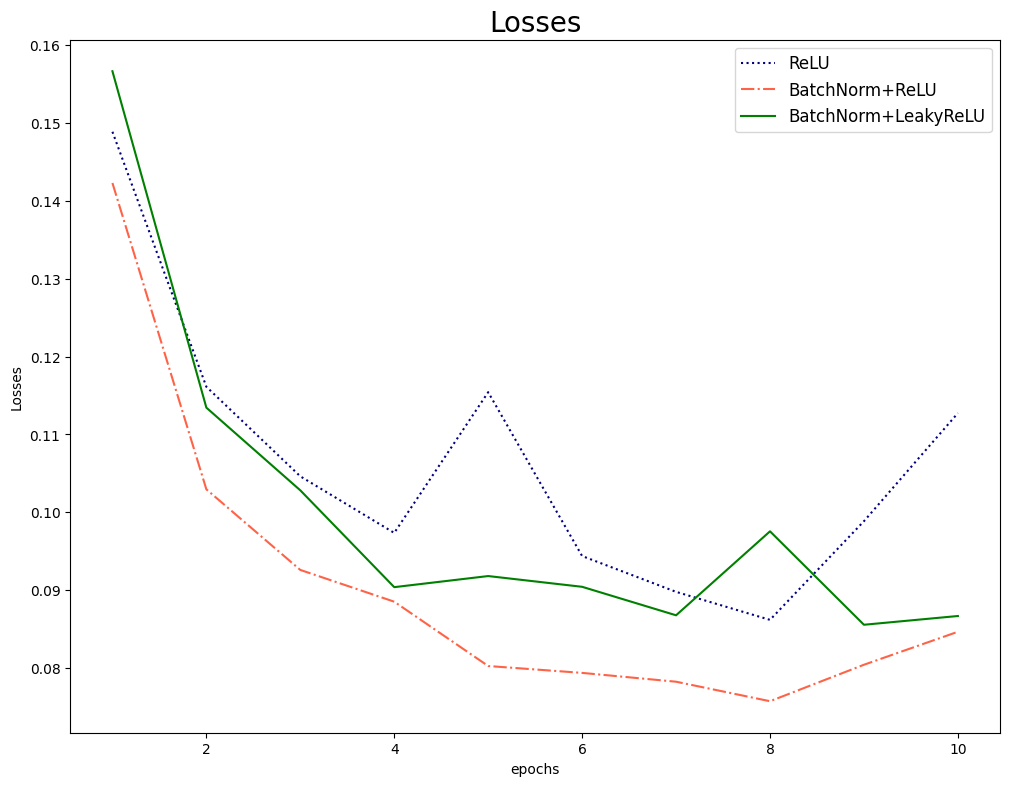

In [12]:
# epoch별 검증 손실의 감소 추이 확인
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(12, 9))
plt.plot(np.arange(1, 11), history_a.history['val_loss'], color='navy', linestyle=':')
plt.plot(np.arange(1, 11), history_b.history['val_loss'], color='tomato', linestyle='-.')
plt.plot(np.arange(1, 11), history_c.history['val_loss'], color='green', linestyle='-')

plt.title('Losses', fontsize=20)
plt.xlabel('epochs')
plt.ylabel('Losses')
plt.legend(['ReLU', 'BatchNorm+ReLU', 'BatchNorm+LeakyReLU'], fontsize=12)
plt.show()

>> mnist 데이터셋은 모델별 차이가 크지는 않지만 좀 더 복잡한 데이터셋을 다룬다면 배치 정규화와 다른 활성화 함수를 적용해 보면서 모델의 훈련 추이를 관찰해 볼 필요가 있음

---

## **6. 모델 저장 및 불러오기**


In [13]:
# mnist 데이터셋 불러오고, 앞의 모델 활용하여 훈련 시키기

import tensorflow as tf

# 케라스의 내장 데이터셋에서 mnist 데이터셋 로드
mnist = tf.keras.datasets.mnist

# load_data()로 데이터셋 로드
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# 데이터 정규화
x_train = x_train / x_train.max()
x_test = x_test / x_test.max()

# 모델 생성
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax'), # 노드는 10개가 되어야 함
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=10)

Epoch 1/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.2358 - accuracy: 0.9301 - val_loss: 0.1240 - val_accuracy: 0.9634
Epoch 2/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0943 - accuracy: 0.9709 - val_loss: 0.0837 - val_accuracy: 0.9745
Epoch 3/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0674 - accuracy: 0.9791 - val_loss: 0.0859 - val_accuracy: 0.9748
Epoch 4/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0491 - accuracy: 0.9844 - val_loss: 0.0788 - val_accuracy: 0.9783
Epoch 5/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0400 - accuracy: 0.9873 - val_loss: 0.0702 - val_accuracy: 0.9794
Epoch 6/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0317 - accuracy: 0.9900 - val_loss: 0.0784 - val_accuracy: 0.9760
Epoch 7/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0288 - accuracy: 0.9911 - val_loss: 0.0889 - val_accur

---

### **6-1. 모델을 파일로 저장**

* 훈련을 종료하여 가중치가 업데이트된 모델 인스턴스를 저장할 수 있음

    * `save()` 메소드를 사용

        -> 메소드를 호출할 때 저장할 파일의 디렉토리를 포함하는 파일명을 매개변수로 지정

* 모델을 저장하는 형식은 HDF5 포맷과 SavedModel 포맷 두 가지가 있음

    * 저장 파일명이 .h5 확장자를 포함하는 경우는 모델이 HDF5 포맷으로 저장함

        -> HDF5 파일 형식은 대용량의 데이터를 저장하기 위한 파일 형식

In [14]:
# 모델명을 h5 포맷으로 저장
model.save('h5-model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


---

### **6-2. 저장된 모델 복원**

* `tensorflow.keras.models.load_model()` 메소드로 저장된 모델 복원 가능

In [15]:
# 모델 복원
h5_model = tf.keras.models.load_model('h5-model.h5')
h5_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_3 (Flatten)         (None, 784)               0         
                                                                 
 dense_15 (Dense)            (None, 256)               200960    
                                                                 
 dense_16 (Dense)            (None, 64)                16448     
                                                                 
 dense_17 (Dense)            (None, 32)                2080      
                                                                 
 dense_18 (Dense)            (None, 10)                330       
                                                                 
Total params: 219818 (858.66 KB)
Trainable params: 219818 (858.66 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


>> 모델 구조가 그대로 복원됨

In [16]:
# 검증 셋을 evaluate 함수에 대입해, 손실함수와 평가지표 계산

# 모델 검증
loss, acc = h5_model.evaluate(x_test, y_test, verbose=0)
print(f'h5_model] loss: {loss:.5f}, acc: {acc:.5f}')

h5_model] loss: 0.09221, acc: 0.97810


* .h5 확장자를 생략하면 SavedModel 포맷으로 저장되며 텐서플로2에서 기본으로 지원하는 파일 포맷임

    -> HDF5와 같은 방식으로 복원하면 됨

In [17]:
# 모델을 SavedModel 포맷으로 저장
model.save('saved-model')

In [18]:
# 모델 복원
saved_model = tf.keras.models.load_model('saved-model')
saved_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_3 (Flatten)         (None, 784)               0         
                                                                 
 dense_15 (Dense)            (None, 256)               200960    
                                                                 
 dense_16 (Dense)            (None, 64)                16448     
                                                                 
 dense_17 (Dense)            (None, 32)                2080      
                                                                 
 dense_18 (Dense)            (None, 10)                330       
                                                                 
Total params: 219818 (858.66 KB)
Trainable params: 219818 (858.66 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [19]:
# 모델 검증(HDF5 포맷)
loss, acc = h5_model.evaluate(x_test, y_test, verbose=0)
print(f'h5_model] loss: {loss:.5f}, acc: {acc:.5f}')

# 모델 검증(SavedModel 포맷)
loss, acc = saved_model.evaluate(x_test, y_test, verbose= 0)
print(f'saved_model] loss: {loss:.5f}, acc: {acc:.5f}')

h5_model] loss: 0.09221, acc: 0.97810
saved_model] loss: 0.09221, acc: 0.97810


>> SavedModel 형식과 HDF5 형식으로 각각 저장 및 복원된 모델들은 동일한 성능을 나타냄

---

## **7. 복잡한 모델 생성**

### **7-1. 함수형 API**

* 함수 형태로 딥러닝 모델을 정의하면 다양하고 복잡한 모델 구조를 구현할 수 있음

    * 함수의 입력 매개변수를 여러 개 갖는 다중 입력, 함수의 return 값을 여러 개 갖는 다중 출력, 같은 레벨에 여러 개의 층을 배치하여 입력과 출력을 공유하는 구조 등 가능

    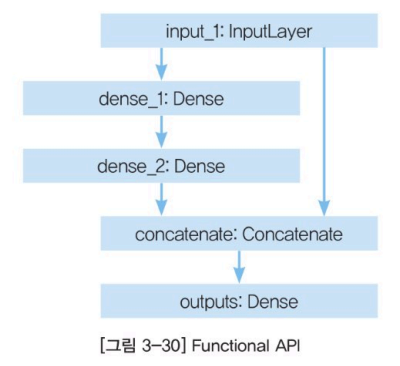

* Sequential API를 사용하는 경우에는 단방향의 Sequential 모델만 구현할 수 있다는 제약이 있음

    -> 데이터 흐름이 특정 레이어를 건너뛰거나, 병합 및 분리하는 등의 구조의 모델을 구현할 수는 없음

* 함수형 API 사용하기

    * 먼저 Input 레이어를 정의하고, Input 레이어에 데이터의 입력 shape을 정의함

    * 레이어마다 반환되는 출력 값을 변수에 저장한 뒤 다음 레이어의 입력으로 연결

        -> 이렇게 여러 개의 레이어를 마치 체인 구조로 입출력을 계속 연결할 수 있음

    * 체인 방식으로 연결한 후에 `tf.keras.Model()`에 `inputs` 매개변수로 입력 레이어, `outputs` 매개변수에 출력 레이어를 정의해 모델을 생성

* 레이어마다 `name` 매개변수로 이름을 부여할 수 있음

    -> 모델 인스턴스에 대하여 `summary()`로 요약 출력할 때 이름이 함께 출력됨






In [20]:
# Sequential API로 구현한 mnist 분류기 모델을 함수형 API로 동일하게 구현

# 모델의 레이어를 체인 구조로 연결 Input 레이어 정의
input_layer = tf.keras.Input(shape=(28, 28), name='InputLayer')

# 모델의 레이어를 체인 구조로 연결
x1 = tf.keras.layers.Flatten(name='Flatten')(input_layer)
x2 = tf.keras.layers.Dense(256, activation='relu', name='Dense1')(x1)
x3 = tf.keras.layers.Dense(64, activation='relu', name='Dense2')(x2)
x4 = tf.keras.layers.Dense(10, activation='softmax', name='OutputLayer')(x3)

In [21]:
# 모델 생성 - 첫 Input 레이어로 시작하여 x4 변수는 마지막 출력층을 나타냄
func_model = tf.keras.Model(inputs=input_layer, outputs=x4, name='FunctionalModel')

# 모델 요약
func_model.summary()

Model: "FunctionalModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 InputLayer (InputLayer)     [(None, 28, 28)]          0         
                                                                 
 Flatten (Flatten)           (None, 784)               0         
                                                                 
 Dense1 (Dense)              (None, 256)               200960    
                                                                 
 Dense2 (Dense)              (None, 64)                16448     
                                                                 
 OutputLayer (Dense)         (None, 10)                650       
                                                                 
Total params: 218058 (851.79 KB)
Trainable params: 218058 (851.79 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


* 복잡한 구조를 갖는 모델을 생성할 때 `summary()`로는 모델의 구조도를 시각화하기 어려움

    -> 케라스의 유틸 패키지에서 제공하는 `plot_model` 모듈을 활용하여 모델 구조도 시각화 가능

* `plot_model()`에 모델 지정하면 구조도 출력

    * `show_shapes=True`로 지정하면 데이터의 입출력 shape 출력

    * `show_layer_names=True`로 지정하면 레이어의 이름 출력

    * 시각화한 구조도를 `to_file` 매개변수에 파일명을 입력하면 이미지 파일로 저장 가능

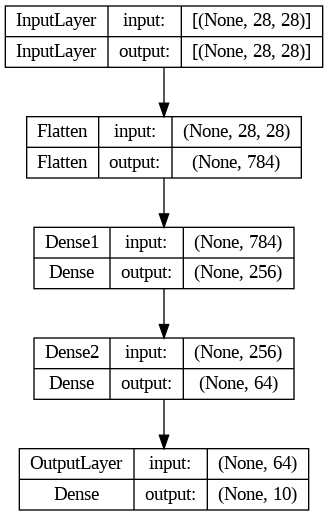

In [22]:
from tensorflow.keras.utils import plot_model

# 구조도 시각화
plot_model(func_model, show_shapes=True, show_layer_names=True, to_file='model.png')

* 함수형 API로 생성한 모델도 Sequential API로 생성한 모델과 동일한 방식으로 훈련할 수 있음

    * 생성된 모델 인스턴스에 `compile()` 메소드로 모델을 컴파일하고 `fit()` 메소드로 모델을 훈련함

        -> 훈련이 완료된 뒤 `evaluate()` 메소드로 검증

In [23]:
# 컴파일
func_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# 훈련
func_model.fit(x_train, y_train, epochs=3)

# 검증
loss, acc = func_model.evaluate(x_test, y_test, verbose=0)
print(f'Functional Model] loss: {loss:.5f}, acc: {acc:.5f}')

Epoch 1/3
1875/1875 [==============================] - 10s 5ms/step - loss: 0.2119 - accuracy: 0.9374
Epoch 2/3
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0908 - accuracy: 0.9715
Epoch 3/3
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0600 - accuracy: 0.9816
Functional Model] loss: 0.07867, acc: 0.97590


---

### **7-2. 모델 서브클래싱**

* 텐서플로 케라스는 Model 클래스를 제공하고, 이를 기반으로 딥러닝 모델을 구현함

    -> 이 클래스를 직접 상속받아 사용자가 직접 서브클래스로 딥러닝 모델을 만들 수도 있음


* Model Subclassing으로 모델 인스턴스를 생성하기 위해서는 `tf.keras.Model`을 상속받아 생성하고자 하는 모델 클래스를 구현함

    * 모델의 `__init__()` 함수에 레이어를 정의하고 레이어의 하이퍼파라미터를 정의함

* `call()` 함수를 메소드 오버라이딩으로 구현

    * `call()` 메소드는 `fit()` 메소드가 호출되어 훈련하는 경우 호출될 함수

    * `call()` 함수 내부에서는 모델의 입력부터 출력까지의 흐름, 즉 순전파를 정의하고 함수형 API와 같은 방식으로 모든 레이어를 체인처럼 연결함

    * 마지막으로 최종 출력 값을 return함

In [24]:
class MyModel(tf.keras.Model):
    def __init__(self):
        super(MyModel, self).__init__()
        # 초기값 설정
        self.flatten = tf.keras.layers.Flatten()
        self.dense1 = tf.keras.layers.Dense(256, activation='relu')
        self.dense2 = tf.keras.layers.Dense(64, activation='relu')
        self.dense3 = tf.keras.layers.Dense(10, activation='softmax')

    # method overiding
    # 훈련용 함수 정의
    # x는 input
    def call(self, x):
        x = self.flatten(x)
        x = self.dense1(x)
        x = self.dense2(x)
        x = self.dense3(x)
        return x

* tf.keras.Model을 상속받아 구현한 모델인 MyModel을 생성자로 인스턴스를 구현

    * 모델에 이름을 부여하려면 모델 인스턴스의 `_name`에 이름을 지정

* 생성자로 객체를 생성한 mymodel 변수에 바로 `summary()`로 요약 출력하는 것은 불가능

    -> input_shape이 정의되지 않아 전체 모델의 구조를 생성해내지 못했기 때문

    -> mymodel에 `Input` 레이어와 함께 shape을 정의해주면 `summary()`로 모델의 요악을 확인할 수 있음

In [25]:
# 모델 생성
mymodel = MyModel()

# 모델의 이름 설정 - 모델 인스턴스에 _name에 이름 지
mymodel._name = 'subclass_model'

# 모델 input 정의 - mymodel에 Input 레이어와 함께 shape 정의해주면 summary()로 모델 요약 확인 가능
mymodel(tf.keras.layers.Input(shape=(28, 28)))

# 모델 요약
mymodel.summary()

Model: "subclass_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_4 (Flatten)         multiple                  0         
                                                                 
 dense_19 (Dense)            multiple                  200960    
                                                                 
 dense_20 (Dense)            multiple                  16448     
                                                                 
 dense_21 (Dense)            multiple                  650       
                                                                 
Total params: 218058 (851.79 KB)
Trainable params: 218058 (851.79 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


* Model Subclassing으로 생성된 모델의 훈련도 동일하게 `compile()` 메소드로 컴파일 후 `fit()` 메소드로 훈련함

    * `evaluate()` 메소드로 모델 성능 검증도 가능

In [26]:
# 컴파일
mymodel.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# 훈련
mymodel.fit(x_train, y_train, epochs=3)

# 검증
loss, acc = mymodel.evaluate(x_test, y_test, verbose=0)
print(f'Subclassing Model] loss: {loss:.5f}, acc: {acc:.5f}')

Epoch 1/3
1875/1875 [==============================] - 13s 6ms/step - loss: 0.2156 - accuracy: 0.9362
Epoch 2/3
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0890 - accuracy: 0.9723
Epoch 3/3
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0615 - accuracy: 0.9805
Subclassing Model] loss: 0.09607, acc: 0.96960


---

### **7-3. 서브클래싱 모델 파라미터를 활용한 생성**

* Model Subclassing으로 생성하는 장점은 생성자 파라미터로 모델 내부 레이어의 하이퍼파라미터를 지정할 수 있다는 점

In [27]:
# 모델 생성자 파라미터 추가해 동적으로 레이어의 유닛 개수 초기화
class MyModel(tf.keras.Model):

    # 생성자 파라미터 추가
    def __init__(self, units, num_classes):
        super(MyModel, self).__init__()
        # 초기값 설정
        self.flatten = tf.keras.layers.Flatten()
        self.dense1 = tf.keras.layers.Dense(units, activation='relu')
        self.dense2 = tf.keras.layers.Dense(units/4, activation='relu')
        self.dense3 = tf.keras.layers.Dense(num_classes, activation='softmax')

    # class overiding
    # 훈련용 함수 정의
    # x는 input
    def call(self, x):
        x = self.flatten(x)
        x = self.dense1(x)
        x = self.dense2(x)
        x = self.dense3(x)
        return x

In [28]:
# 기준이 되는 unit의 개수 입력받아 Dense 레이어의 유닛 개수 계산하여 설정

# 모델 생성
mymodel = MyModel(256, 10)

# 모델 input 정의
mymodel(tf.keras.layers.Input(shape=(28, 28)))

# 모델 요약
mymodel.summary()

Model: "my_model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_5 (Flatten)         multiple                  0         
                                                                 
 dense_22 (Dense)            multiple                  200960    
                                                                 
 dense_23 (Dense)            multiple                  16448     
                                                                 
 dense_24 (Dense)            multiple                  650       
                                                                 
Total params: 218058 (851.79 KB)
Trainable params: 218058 (851.79 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


>> 모델 생성자에 생성자 파라미터로 초기화하여 생성한 모델에 summary()로 확인한 결과 동적으로 설정한 레이어의 파라미터 초기화됨

In [29]:
# 컴파일
mymodel.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# 훈련
mymodel.fit(x_train, y_train, epochs=3)

# 검증
loss, acc = mymodel.evaluate(x_test, y_test, verbose=0)
print(f'Subclassing Model w.parameters] loss: {loss:.5f}, acc: {acc:.5f}')

Epoch 1/3
1875/1875 [==============================] - 12s 6ms/step - loss: 0.2090 - accuracy: 0.9374
Epoch 2/3
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0877 - accuracy: 0.9732
Epoch 3/3
1875/1875 [==============================] - 13s 7ms/step - loss: 0.0603 - accuracy: 0.9810
Subclassing Model w.parameters] loss: 0.08759, acc: 0.97330


>> 이렇게 생성한 모델도 동일하게 `compile()` 메소드로 컴파일 한 뒤 `fit()` 메소드로 훈련함

>> 훈련이 완료된 뒤 모델 인스턴스의 `evaluate()` 메소드로 모델의 성능 검증 가능